In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')
import re 


from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_score, recall_score, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler


from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [2]:
data = pd.read_csv('datasets/graduate/train_dataset_bank.csv', encoding='cp1251', sep=';').drop_duplicates()
data.columns = data.columns.str.lower()


data = data.drop(columns=['id_contract', 'id_client'])

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17891 entries, 0 to 17890
Columns: 122 entries, sign_date to citizenship_name
dtypes: float64(108), int64(2), object(12)
memory usage: 16.8+ MB


,sign_date,ip_flag,target,f1100,f1110,f1150,f1160,f1170,f1180,f1190,...,winnernumber_95_ever,signednumber_95_ever,sum_95_ever,flag_disqualification,count_change_year,count_change_ever,birthdate,age,sex_name,citizenship_name
0,01JAN2018:00:00:00,0,0,1.298961e+09,2154000.0,1.125573e+09,NaN,150010000.0,NaN,21224000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01JAN2018:00:00:00,0,0,7.337400e+07,NaN,7.337400e+07,NaN,NaN,NaN,NaN,...,169.0,168.0,18351739.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3,01JAN2018:00:00:00,0,0,1.937488e+09,122828000.0,6.103280e+08,NaN,809426000.0,356828000.0,38078000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#  Удаление столбцов с большим количеством пропусков.

Тк у нас есть 2 вида клиентов в ip_flag: 1(физ лица), у них все столбцы с доходами компнаии не имеют никаких значений, поэтому физ лица неначем предсказывать. 

# Что по физ лицам, анализ и что делаем

In [3]:
columns_to_plot = list(data.select_dtypes(['float64']).columns) 
len(columns_to_plot)

108

Выбрал все колонки с какой то информацией.

In [4]:
df_nan = pd.DataFrame(data={'birthdate' : data[data['ip_flag']==1]['birthdate'].isna().value_counts()}, columns=['birthdate'])

for column in columns_to_plot:
    df_nan[column] = data[data['ip_flag']==1][column].isna().value_counts()

In [5]:
df_nan

,birthdate,f1100,f1110,f1150,f1160,f1170,f1180,f1190,f1200,f1210,...,sum_95_year,admittednumber_95_ever,notadmittednumber_ever,winnernumber_95_ever,signednumber_95_ever,sum_95_ever,flag_disqualification,count_change_year,count_change_ever,age
True,2081,3500.0,3500.0,3500.0,3500.0,3500.0,3500.0,3500.0,3500.0,3500.0,...,3500.0,3500.0,3500.0,3500.0,3500.0,3500.0,3500.0,3500.0,3500.0,2081
False,1419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1419


Создал DF с колвом пропусков по столбцам.

In [6]:
df_nan.iloc[1].isna().value_counts()

True     93
False    16
dtype: int64

Посчитал, оказалось что только в 16 столбцах из 108 столбцов, есть хоть какие то значения.

In [7]:
save = df_nan.iloc[1].isna()
save[save==False]

birthdate                     False
okato_regioncode              False
okato_fed                     False
oktmo_code                    False
oktmo_fed                     False
plaintiff_casesnumber_year    False
plaintiff_sum_year            False
defendant_casesnumber_year    False
defendant_sum_year            False
thirdorotherperson_year       False
plaintiff_casesnumber_ever    False
plaintiff_sum_ever            False
defendant_casesnumber_ever    False
defendant_sum_ever            False
thirdorotherperson_ever       False
age                           False
dtype: bool

Это столбцы с возрастом и образениями в суд, с этими данными ничего не сделать, только если у нас в таргете есть доминация, только тогда оставлю физлица.

In [8]:
data[data['ip_flag']==1]['target'].value_counts()

0    2288
1    1212
Name: target, dtype: int64

У нас нет доминации, удалю все значения где ip_flag=1, предсказывать мы его не сможем.  Так же удалю сам ip_flag.

In [9]:
data = data.loc[data['ip_flag'] == 0]
data = data.drop(columns=['ip_flag'])

# ИП лица.

In [10]:
data = data.drop(columns=['f1150_lag1', 'f1230_lag1', 'f1410_lag1', 'f1510_lag1', 'f1520_lag1', 'f2110_lag1',
                 'f2120_lag1', 'f2200_lag1', 'f2210_lag1', 'f2220_lag1', 'f2300_lag1', 'f2320_lag1', 'f2330_lag1', 'f2400_lag1'])

Удалю лаги, они сильно корелирует между собой, так что я их дропну! 
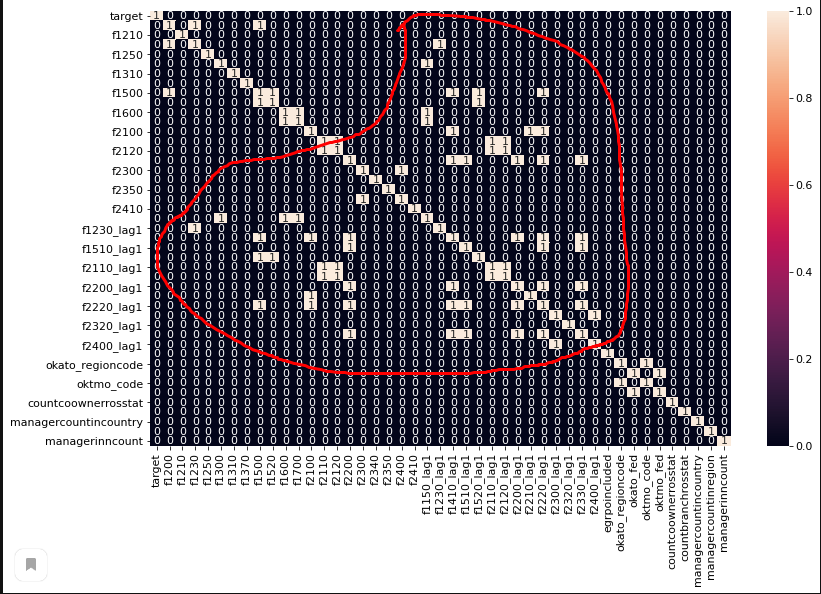

In [11]:
columns_group = ['f1110', 'f1150', 'f1160', 'f1170', 'f1180', 'f1190', 'f1200', 'f1210', 'f1220', 'f1230', 'f1240', 'f1250', 'f1260', 'f1300', 'f1310', 'f1320', 'f1350', 
                 'f1360', 'f1370', 'f1400', 'f1410', 'f1420', 'f1450', 'f1500', 'f1510', 'f1520', 'f1530', 'f1550', 'f1600', 'f1700', 'f2100', 'f2110', 'f2120', 'f2200', 'f2210', 
                 'f2220', 'f2300', 'f2310', 'f2320', 'f2330' ,'f2340', 'f2350', 'f2400', 'f2410']

df_nan = pd.DataFrame(data={'f1100' : data['f1100'].isna().value_counts(normalize=True)}, columns=['f1100'])

for column in columns_group:
    df_nan[column] = data[column].isna().value_counts(normalize=True)




In [12]:
column_to_drop = df_nan.iloc[0]>0.5
column_to_drop = list(column_to_drop[column_to_drop == True].index)
column_to_drop

['f1100',
 'f1110',
 'f1150',
 'f1160',
 'f1170',
 'f1180',
 'f1190',
 'f1220',
 'f1240',
 'f1260',
 'f1320',
 'f1350',
 'f1360',
 'f1400',
 'f1410',
 'f1420',
 'f1450',
 'f1510',
 'f1530',
 'f1550',
 'f2210',
 'f2220',
 'f2310',
 'f2320',
 'f2330']

In [13]:
data = data.drop(columns=column_to_drop)

Выбираю все колонки где больше 50% пропусков.

In [14]:
check = ['plaintiff_casesnumber_year', 'plaintiff_sum_year', 'defendant_casesnumber_year', 'defendant_sum_year', 'thirdorotherperson_year', 'plaintiff_casesnumber_ever', 'plaintiff_sum_ever', 
'defendant_casesnumber_ever', 'defendant_sum_ever', 'thirdorotherperson_ever', 'admittednumber_233_year', 'notadmittednumber_233_year', 'winnernumber_233_year', 'signednumber_233_year', 
'sum_233_year', 'admittednumber_233_ever', 'notadmittednumber_233_ever', 'winnernumber_233_ever', 'signednumber_233_ever', 'sum_233_ever', 'admittednumber_95_year', 'notadmittednumber_95_year', 
'winnernumber_95_year', 'signednumber_95_year', 'sum_95_year', 'admittednumber_95_ever', 'notadmittednumber_ever', 'winnernumber_95_ever', 'signednumber_95_ever', 'sum_95_ever', 'flag_disqualification', 
'count_change_year', 'count_change_ever']


df_nan = pd.DataFrame(data={'plaintiff_casesnumber_year' : data['plaintiff_casesnumber_year'].isna().value_counts(normalize=True)}, columns=['plaintiff_casesnumber_year'])

for column in check:
    df_nan[column] = data[column].isna().value_counts(normalize=True)


Данные по судимостям удаляю, но не пытаюсь заполнить, я перед этим проверил что 0 там есть, соответсвенно заполнять нулями не логично.

In [15]:
dubl_col = df_nan.iloc[0]>0.5
dubl_col = list(dubl_col[dubl_col == True].index)
dubl_col

['plaintiff_casesnumber_year',
 'plaintiff_sum_year',
 'defendant_casesnumber_year',
 'defendant_sum_year',
 'thirdorotherperson_year',
 'plaintiff_casesnumber_ever',
 'plaintiff_sum_ever',
 'defendant_casesnumber_ever',
 'defendant_sum_ever',
 'thirdorotherperson_ever',
 'admittednumber_233_year',
 'notadmittednumber_233_year',
 'winnernumber_233_year',
 'signednumber_233_year',
 'sum_233_year',
 'admittednumber_233_ever',
 'notadmittednumber_233_ever',
 'winnernumber_233_ever',
 'signednumber_233_ever',
 'sum_233_ever',
 'admittednumber_95_year',
 'notadmittednumber_95_year',
 'winnernumber_95_year',
 'signednumber_95_year',
 'sum_95_year',
 'admittednumber_95_ever',
 'notadmittednumber_ever',
 'winnernumber_95_ever',
 'signednumber_95_ever',
 'sum_95_ever',
 'flag_disqualification',
 'count_change_year',
 'count_change_ever']

Удалил все столбцы с пропусками больше 50%

In [16]:
data = data.drop(columns=dubl_col)

### Так же удалю данные о дублирующие колонках.

In [17]:
data = data.drop(columns = ['countcoowneregrul', 'countcoownerfcsm', 'countbranch', 'countbranchegrul', 'telephonecount'])

## Пропуски в object признаках.

In [18]:
def class_bar(data, sign, x=8, y=5):
    df = data.copy()
    df_row = (df[sign].value_counts(normalize = True) * 100).reset_index()
    
    
    plt.gcf().set_size_inches(x, y)
    plt.rcParams.update({'font.size': 11})
    sns.barplot(x = 'index', y = sign, data = df_row, edgecolor='.1', saturation = 1)
    for index, row_text in df_row.iterrows():
            plt.text(index, row_text[sign] * 1.01, '{}%'.format(round(row_text[sign], 1)), color = 'black', ha = 'center')
        
        
    plt.ylim([0, 250])
    plt.grid(axis = 'y')
    plt.xlabel('Класс')
    plt.ylabel('Доля класса')
    plt.title(f'Диаграмма классового баланса признака: {sign}')
    plt.show()

In [19]:
columns_to_plot = list(data.select_dtypes(['object']).columns) 
columns_to_plot

['sign_date',
 'datefirstreg',
 'okfs_group',
 'okopf_group',
 'okogu_group',
 'workersrange',
 'taxreg_regdate',
 'taxregpay_regdate',
 'okved_code',
 'birthdate',
 'sex_name',
 'citizenship_name']

In [20]:
df_nan = pd.DataFrame(data={'okogu_group' : data['okogu_group'].isna().value_counts()}, columns=['okogu_group'])

for column in columns_to_plot:
    df_nan[column] = data[column].isna().value_counts()

df_nan

,okogu_group,sign_date,datefirstreg,okfs_group,okopf_group,workersrange,taxreg_regdate,taxregpay_regdate,okved_code,birthdate,sex_name,citizenship_name
False,14388,14391.0,14389,14391.0,14391.0,13911,14386,14295,14381,NaN,NaN,NaN
True,3,NaN,2,NaN,NaN,480,5,96,10,14391.0,14391.0,14391.0


Дропаем birthdate, sex_name, citizenship_name. Остальные пропуски, я просто дропну, меньше 10%.

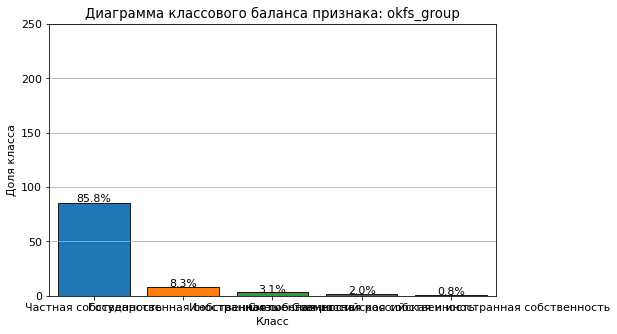

In [21]:
class_bar(data, 'okfs_group')

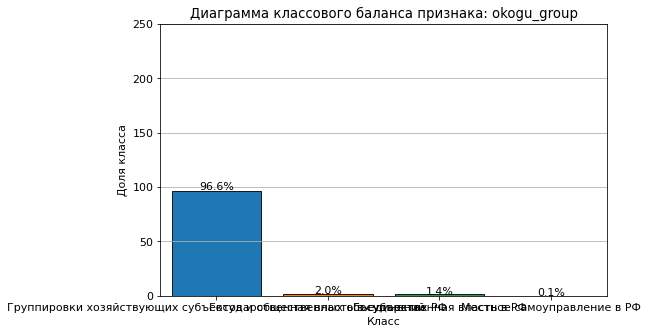

In [22]:
class_bar(data, 'okogu_group')

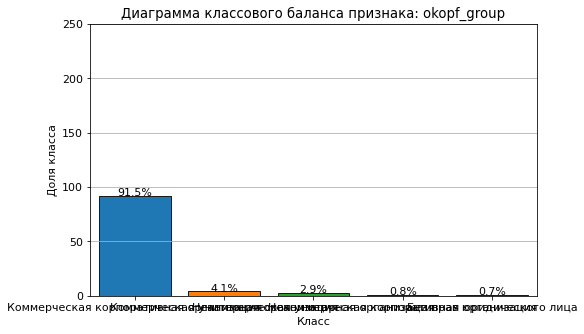

In [23]:
class_bar(data, 'okopf_group')

Так же удалю все группы, слишком большой дисбаланс, чтобы его оставлять.

In [24]:
data = data.drop(columns=['birthdate', 'sex_name', 'citizenship_name', 'okfs_group', 'okogu_group', 'okopf_group', 'age', 'oktmo_fed'])

<AxesSubplot:>

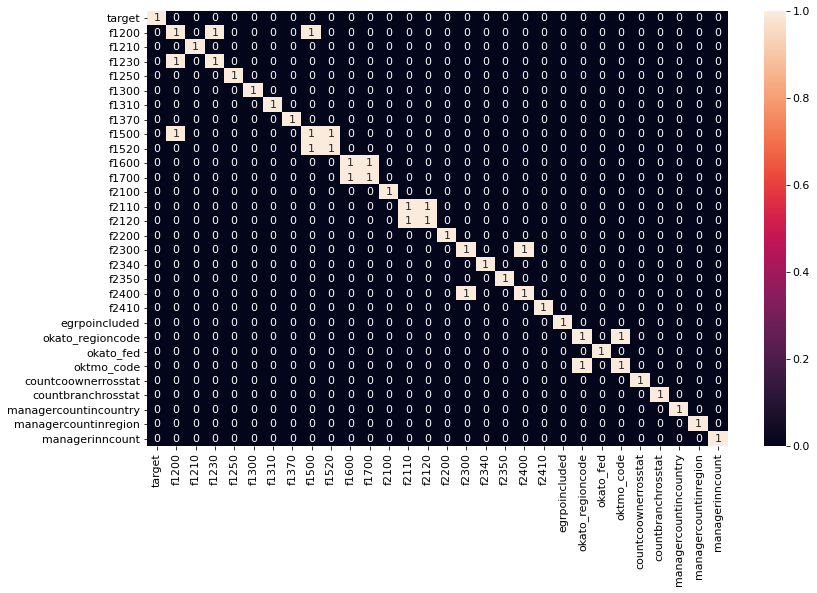

In [25]:
plt.figure(figsize=(13, 8))
sns.heatmap(data.corr()>0.9, annot=True)

In [26]:
data = data.drop(columns=['f1200', 'f1500', 'f1700', 'f2120', 'f2300', 'okato_fed', 'okato_regioncode'])

Удалил все коррелирующие признаки.

# Заполнение пропусков.
#### okved_code

In [27]:
data['okved_code'] = data['okved_code'].fillna('9999')
data['okved_code'] = data['okved_code'].apply(lambda x: int(str(x).split('.')[0]))
data['okved_code']

0        35
2        36
3        35
5        84
7        35
         ..
17886    36
17887    86
17888    46
17889    46
17890    43
Name: okved_code, Length: 14391, dtype: int64

Заполнил пропуски в оkved выбивающиемся значениями, так же выбрал первые 2 цифры в коде, для упрощения кодирования.
#### workersrange
Беру первую границу во всех строках. Пропуски заполню выбивающиемся значениями

In [28]:
data['workersrange'] = data['workersrange'].fillna('-9999')
data['workersrange'] = data['workersrange'].apply(lambda x: int(str(x).split()[0]))
data['workersrange']

0        1001
2          51
3         501
5        5000
7        5000
         ... 
17886      51
17887    1001
17888       0
17889       0
17890      16
Name: workersrange, Length: 14391, dtype: int64

### Все пропуски в float признаках.

In [29]:
to_fillna = ['f1210', 'f1230', 'f1250', 'f1300', 'f1310', 'f1370', 'f1520', 'f1600', 'f2100', 'f2110', 'f2200', 'f2340', 'f2350', 'f2400', 'f2410']

for column in to_fillna:
    data[column] = data[column].fillna(data[column].median())
    
data = data.dropna()

Заполнил пропуски медианой.<br>
<strong>Остальные пропуски я дропаю, тк пропусков меньше 10% процентов.</strong>

## Добавление временных колонок.
Добавил год и месяц регистрации, и добавил годы регистрации в налоговой.

In [30]:
data['sign_year'] = data['sign_date'].apply(lambda x: int(re.search('\d{4}', str(x))[0]))
data['sign_month'] = data['sign_date'].apply(lambda x: re.search('\D{3}', str(x))[0])

data['firstreg_year'] = data['datefirstreg'].apply(lambda x: int(re.search('\d{4}', str(x))[0]))
data['firstreg_month'] = data['datefirstreg'].apply(lambda x: re.search('\D{3}', str(x))[0])

data['taxreg_year'] = data['taxreg_regdate'].apply(lambda x: int(re.search('\d{4}', str(x))[0]))


## Преображение кодов.
Oktmo коды:

In [31]:
len(data['oktmo_code'].unique())

1512

In [32]:
oktmo_cnts = data['oktmo_code'].value_counts()
rare_oktmo_vls = oktmo_cnts[oktmo_cnts < data.shape[0] * 0.01].index.values
data.loc[data['oktmo_code'].isin(rare_oktmo_vls), 'oktmo_code']  = -9999

data['oktmo_code'] = data['oktmo_code'].astype('int')

In [33]:
len(data['oktmo_code'].unique())

2

### Кодировка.

In [34]:
label_columns = ['sign_month', 'firstreg_month']
le = LabelEncoder()
for column in label_columns:
    le.fit(data[column])
    data[column] = le.transform(data[column])

In [35]:
columns_to_drop = list(data.select_dtypes(['object']).columns) 
data = data.drop(columns=columns_to_drop)

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14295 entries, 0 to 17890
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   target                 14295 non-null  int64  
 1   f1210                  14295 non-null  float64
 2   f1230                  14295 non-null  float64
 3   f1250                  14295 non-null  float64
 4   f1300                  14295 non-null  float64
 5   f1310                  14295 non-null  float64
 6   f1370                  14295 non-null  float64
 7   f1520                  14295 non-null  float64
 8   f1600                  14295 non-null  float64
 9   f2100                  14295 non-null  float64
 10  f2110                  14295 non-null  float64
 11  f2200                  14295 non-null  float64
 12  f2340                  14295 non-null  float64
 13  f2350                  14295 non-null  float64
 14  f2400                  14295 non-null  float64
 15  f2

### Чистка выбросов.

In [37]:
def boxplot_clear(data, column):
    
    data_to_clear = data
    
    
    print(f'___________________BEFORE CLEAR: {column}___________________\n\n')
    sns.boxplot(data[column])
    plt.show()

    
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    first_border = Q1 - 1.5*IQR
    second_border = Q3 + 1.5*IQR
    
    cleared_data = data_to_clear[(data_to_clear[column] >= first_border) & (data_to_clear[column] <= second_border)] # 
    
    
    
    print(f'___________________AFTER CLEAR: {column}________________\n\n')
    sns.boxplot(cleared_data[column])
    plt.show()
    sns.histplot(cleared_data[column])
    plt.show()
    
    
    
    print(f'Границы чистки выбросов: от:{first_border} до:{second_border}\n\n\n')
    
    
    return cleared_data

___________________BEFORE CLEAR: managercountincountry___________________




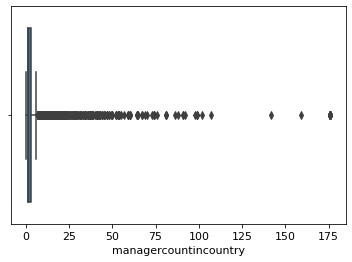

___________________AFTER CLEAR: managercountincountry________________




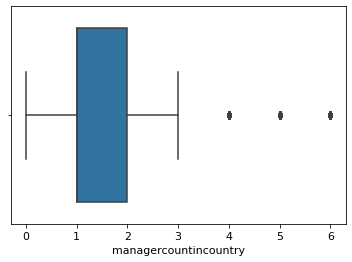

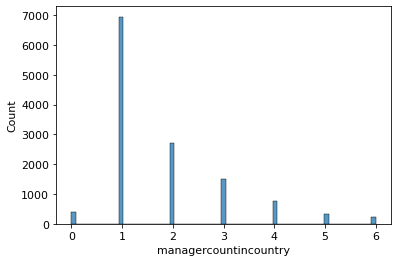

Границы чистки выбросов: от:-2.0 до:6.0





In [38]:
data = boxplot_clear(data,'managercountincountry')

___________________BEFORE CLEAR: f1210___________________




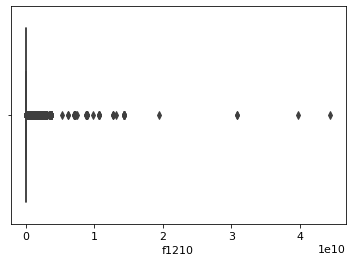

___________________AFTER CLEAR: f1210________________




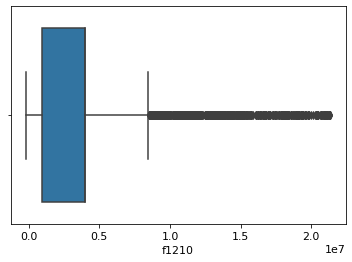

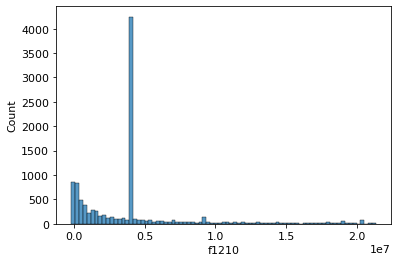

Границы чистки выбросов: от:-10448500.0 до:21395500.0





In [39]:
data = boxplot_clear(data,'f1210')

___________________BEFORE CLEAR: f1230___________________




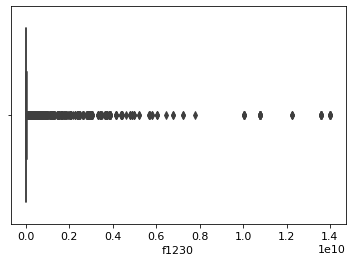

___________________AFTER CLEAR: f1230________________




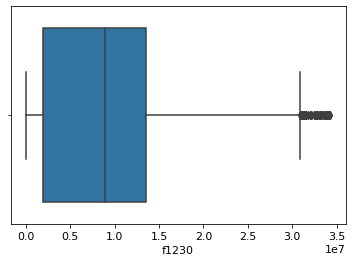

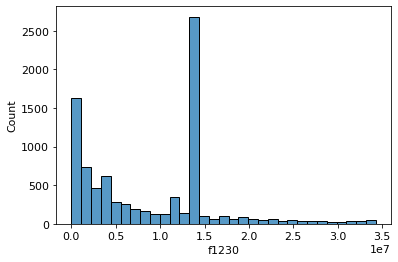

Границы чистки выбросов: от:-16060750.0 до:34513250.0





In [40]:
data = boxplot_clear(data,'f1230')

___________________BEFORE CLEAR: f1250___________________




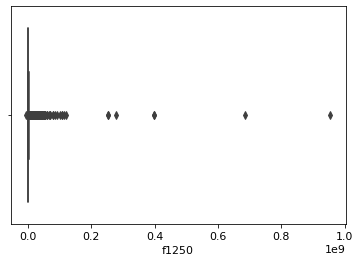

___________________AFTER CLEAR: f1250________________




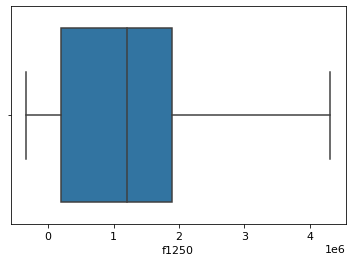

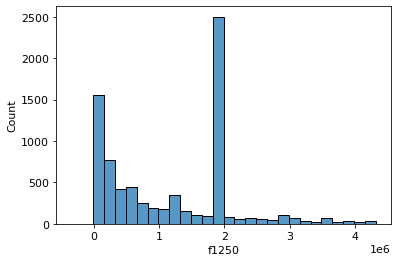

Границы чистки выбросов: от:-2147000.0 до:4317000.0





In [41]:
data = boxplot_clear(data,'f1250')

___________________BEFORE CLEAR: f1300___________________




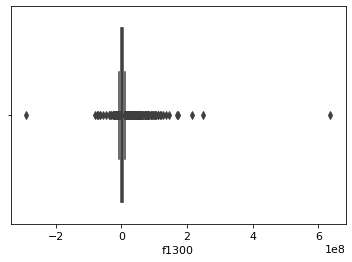

___________________AFTER CLEAR: f1300________________




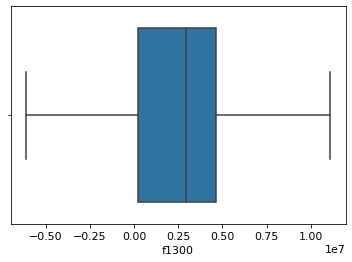

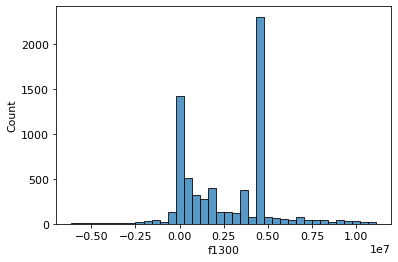

Границы чистки выбросов: от:-6174750.0 до:11119250.0





In [42]:
data = boxplot_clear(data,'f1300')

___________________BEFORE CLEAR: f1370___________________




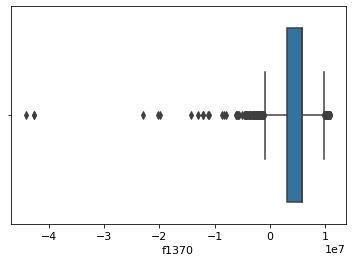

___________________AFTER CLEAR: f1370________________




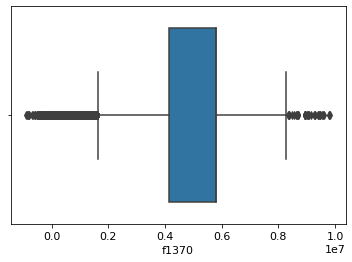

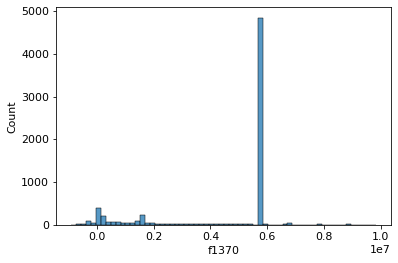

Границы чистки выбросов: от:-960500.0 до:9851500.0





In [43]:
data = boxplot_clear(data,'f1370')

___________________BEFORE CLEAR: f1520___________________




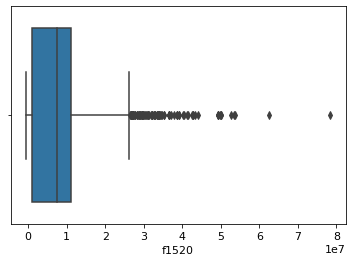

___________________AFTER CLEAR: f1520________________




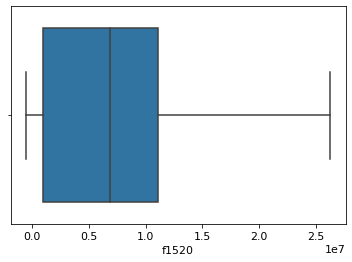

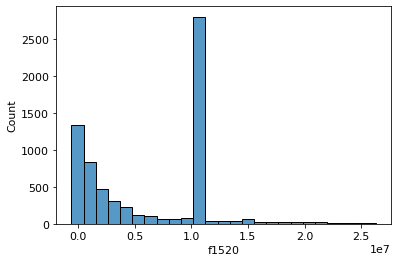

Границы чистки выбросов: от:-14222000.0 до:26306000.0





In [44]:
data = boxplot_clear(data,'f1520')

___________________BEFORE CLEAR: f1600___________________




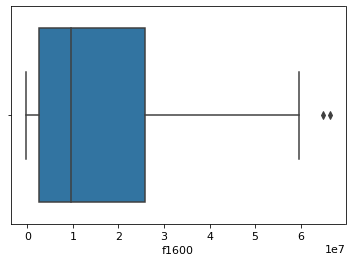

___________________AFTER CLEAR: f1600________________




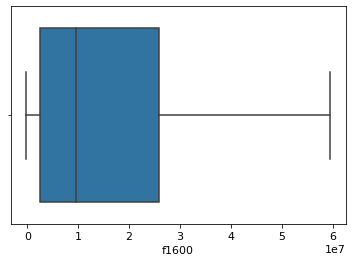

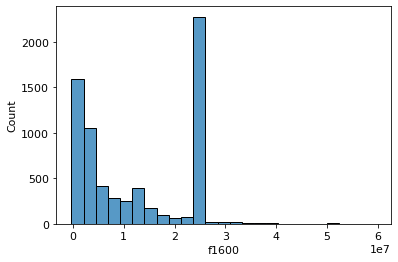

Границы чистки выбросов: от:-32367750.0 до:60674250.0





In [45]:
data = boxplot_clear(data,'f1600')

___________________BEFORE CLEAR: f2100___________________




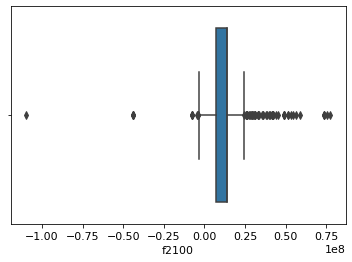

___________________AFTER CLEAR: f2100________________




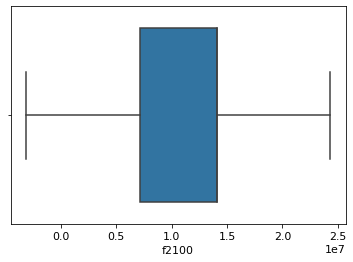

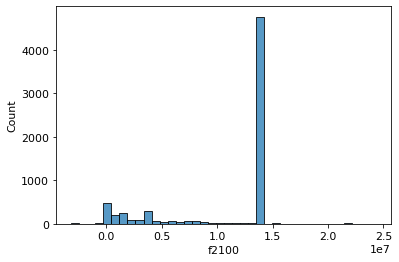

Границы чистки выбросов: от:-3304250.0 до:24469750.0





In [46]:
data = boxplot_clear(data,'f2100')

___________________BEFORE CLEAR: f2110___________________




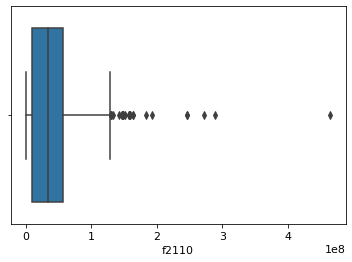

___________________AFTER CLEAR: f2110________________




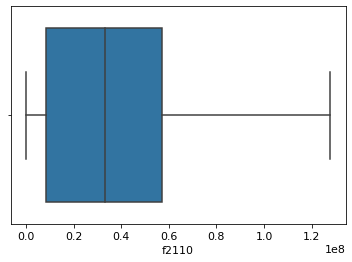

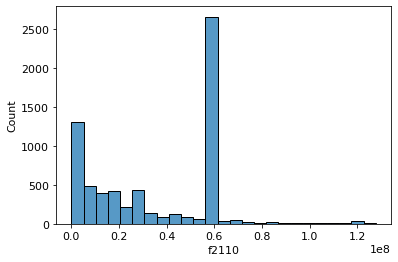

Границы чистки выбросов: от:-63780750.0 до:129393250.0





In [47]:
data = boxplot_clear(data,'f2110')

___________________BEFORE CLEAR: f2200___________________




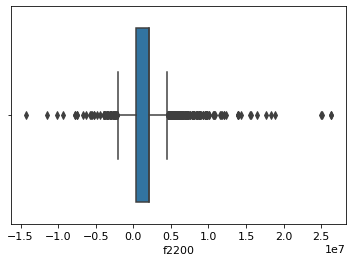

___________________AFTER CLEAR: f2200________________




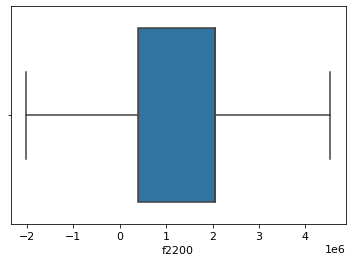

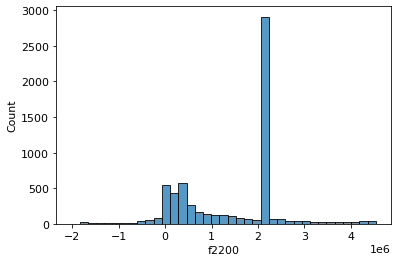

Границы чистки выбросов: от:-2104000.0 до:4560000.0





In [48]:
data = boxplot_clear(data,'f2200')

___________________BEFORE CLEAR: f2350___________________




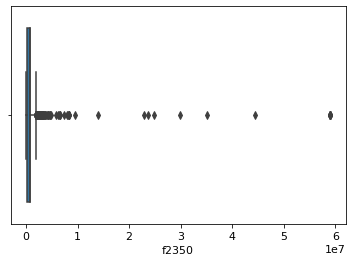

___________________AFTER CLEAR: f2350________________




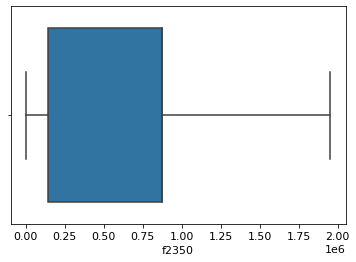

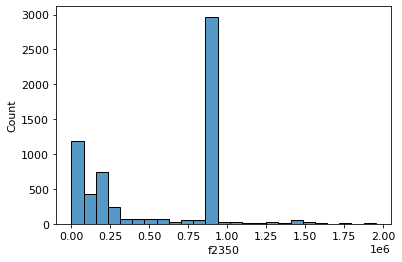

Границы чистки выбросов: от:-940625.0 до:1964375.0





In [49]:
data = boxplot_clear(data,'f2350')

___________________BEFORE CLEAR: f2400___________________




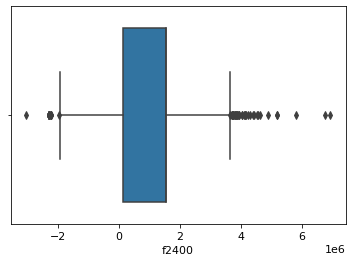

___________________AFTER CLEAR: f2400________________




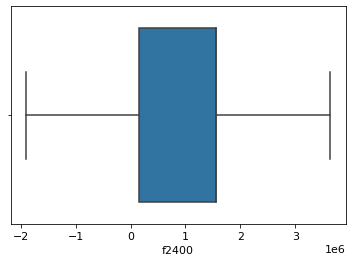

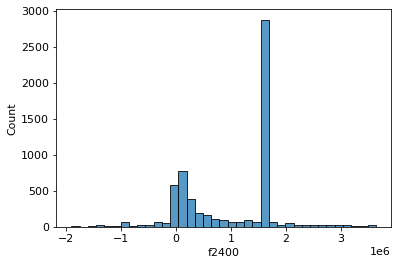

Границы чистки выбросов: от:-1943750.0 до:3658250.0





In [50]:
data = boxplot_clear(data,'f2400')

___________________BEFORE CLEAR: f2410___________________




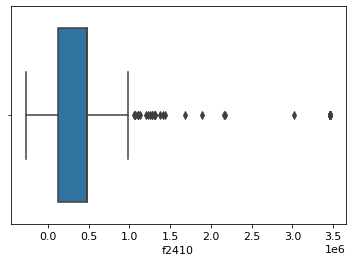

___________________AFTER CLEAR: f2410________________




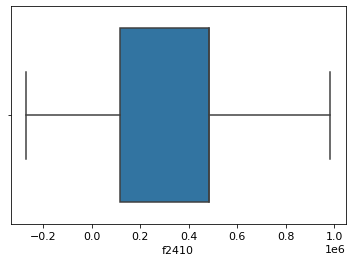

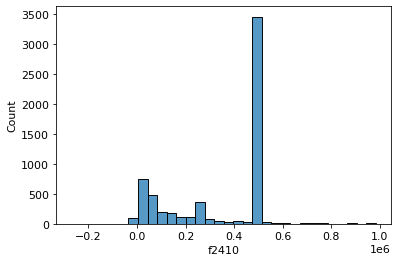

Границы чистки выбросов: от:-423000.0 до:1025000.0





In [51]:
data = boxplot_clear(data,'f2410')

In [52]:
to_drop = ['f1310', 'f2340']
data = data.drop(columns=to_drop)

Удалил колонки 'f1310', 'f2340', выяснил что после очистки там остается только 1 значение, так что смысла их хранить не вижу.

### Создал рентабельность бизнеса и почистил выбросы.

In [53]:
data['rent'] = (data['f2200']/data['f2110'])*100

___________________BEFORE CLEAR: rent___________________




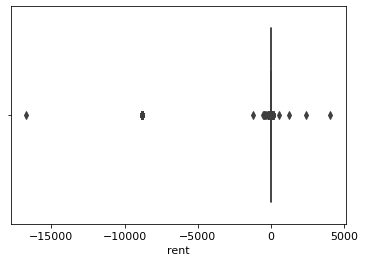

___________________AFTER CLEAR: rent________________




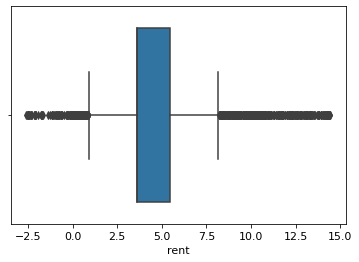

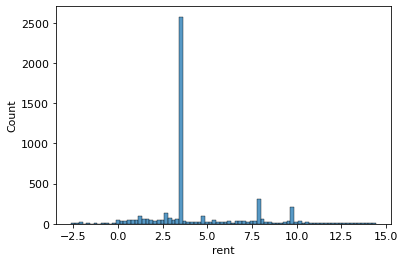

Границы чистки выбросов: от:-2.8829114351557865 до:14.454914724024707





In [54]:
data = boxplot_clear(data,'rent')

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5215 entries, 18 to 17888
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   target                 5215 non-null   int64  
 1   f1210                  5215 non-null   float64
 2   f1230                  5215 non-null   float64
 3   f1250                  5215 non-null   float64
 4   f1300                  5215 non-null   float64
 5   f1370                  5215 non-null   float64
 6   f1520                  5215 non-null   float64
 7   f1600                  5215 non-null   float64
 8   f2100                  5215 non-null   float64
 9   f2110                  5215 non-null   float64
 10  f2200                  5215 non-null   float64
 11  f2350                  5215 non-null   float64
 12  f2400                  5215 non-null   float64
 13  f2410                  5215 non-null   float64
 14  egrpoincluded          5215 non-null   float64
 15  ok

## Деление на обучающие и тестовые данные.

In [56]:
features = data.drop(columns=['target'])
target =  data['target']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=666, stratify=target)

print(features_train.shape, target_train.shape)
print(features_test.shape, target_test.shape)

(3911, 28) (3911,)
(1304, 28) (1304,)


In [57]:
categorical_features = ['sign_month', 'egrpoincluded', 'okved_code', 'oktmo_code']

In [58]:
def learn_model(models, features_train, features_test, target_train, target_test, title='', categorical_feature = categorical_features):
    
    def predict(model, train_predict, target_train, test_predict, target_test):
        
        metrics = {'f1' : f1_score,
                   'accuracy' : accuracy_score,
                   'roc auc score' : roc_auc_score,
                   'precision' : precision_score,
                   'recall' : recall_score
                  }
        columns = ['train', 'test']
        data = []
        for metric in metrics.keys():
            data.append([metrics[metric](target_train, train_predict) ,metrics[metric](target_test, test_predict)])


        results = pd.DataFrame(data=data, index=metrics.keys(), columns=columns)
        
        print(results)
        print()
    
    def fit_model():
        

        plot_data = {}
        learned_model = {}
        
        for model in models.keys():
            print(f'__________{model}__________')
            model_learn = models[model][0]
            params = models[model][1]
            
            start_time = time.time()
            
            grid = GridSearchCV(model_learn, cv=3, param_grid=params, n_jobs=-1, scoring = 'f1')
            
            if model == 'LightGBM':
                grid.fit(features_train, target_train, categorical_feature=categorical_feature)
            else:
                grid.fit(features_train, target_train)
                
            end_time = time.time()
            fit_time = end_time - start_time
            
            plot_data[model] = fit_time # время обучения модели
            learned_model[model] = [grid, grid.best_params_] # сохраняем модель
            
            
            
            train_predict = grid.predict(features_train)
            test_predict = grid.predict(features_test)
            
            predicted = predict(model, train_predict, target_train, test_predict, target_test)
            
            
        sns.barplot(x=list(plot_data.keys()), y=list(plot_data.values()), saturation=1)    
        plt.xlabel('Модели')
        plt.ylabel('Время')
        plt.title(f'Время обучения {title}')
        plt.show()
        
        return learned_model
        
        
    result_model = fit_model()    
    
    
        
    return result_model
            


In [59]:
models = {'Linear' : [LogisticRegression(random_state=666, n_jobs=-1), {'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
                                                                        'penalty':['l1', 'l2'], 
                                                                        'class_weight':['balanced', None]}],
         'Forest' : [RandomForestClassifier(random_state=666, n_jobs=-1), {'max_depth':range(1, 10),
                                                                            'min_samples_leaf':range(1,10),
                                                                            'min_samples_split':range (2, 10,2)}],
          
          'Tree': [DecisionTreeClassifier(random_state=666), {'max_depth':range(1, 15),
                                                              'min_samples_leaf':range(1 ,15),
                                                              'min_samples_split':range (2, 17,2)}],
          
          'LightGBM' : [LGBMClassifier(random_state=666, n_jobs=-1), {'learning_rate':[0.001, 0.01, 0.1], 
                                                                     'max_depth':range(1, 15),
                                                                     'n_estimators':range(1, 500, 25)}],
          
          'CatBoost' : [CatBoostClassifier(random_state=666, silent=True), {'learning_rate':[0.01, 0.1], 
                                                                            'max_depth':range(1, 10),
                                                                            'n_estimators':range(500, 2000, 250)}],
          'XGBClassifier' : [XGBClassifier(n_jobs=-1), {'max_depth':range(1, 10),
                                                       'learning_rate':[0.01, 0.1],
                                                       'n_estimators':range(50, 500, 50)}]
         }

__________Linear__________
                  train      test
f1             0.781431  0.769978
accuracy       0.690616  0.673313
roc auc score  0.627065  0.607544
precision      0.695051  0.682950
recall         0.892327  0.882426

__________Forest__________
                  train      test
f1             0.926509  0.869671
accuracy       0.905651  0.835890
roc auc score  0.888662  0.820864
precision      0.895649  0.856115
recall         0.959571  0.883663

__________Tree__________
                  train      test
f1             0.906020  0.849821
accuracy       0.879059  0.806748
roc auc score  0.859672  0.782947
precision      0.873898  0.819540
recall         0.940594  0.882426

__________LightGBM__________
                  train      test
f1             0.996301  0.887218
accuracy       0.995398  0.861963
roc auc score  0.993948  0.857474
precision      0.992629  0.898477
recall         1.000000  0.876238

__________CatBoost__________
                  train      test
f1       

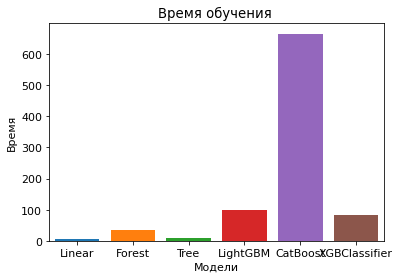

Wall time: 14min 59s


In [60]:
%%time
models = learn_model(models, features_train, features_test, target_train, target_test)

### Catboost модель и feature importances.

In [61]:
model = CatBoostClassifier(random_state=666, silent=True, iterations=500, max_depth=8, learning_rate=0.1)
model.fit(features_train, target_train)

predictions = model.predict(features_test)

In [62]:
print(classification_report(target_test, predictions))
print(f1_score(target_test, predictions))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       496
           1       0.89      0.88      0.89       808

    accuracy                           0.86      1304
   macro avg       0.85      0.86      0.85      1304
weighted avg       0.86      0.86      0.86      1304

0.8870867124142233


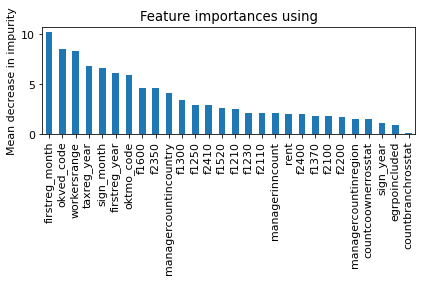

In [63]:
importances = model.feature_importances_

feature_importances = pd.Series(importances, index=features_train.columns).sort_values(ascending=False)

fig, ax = plt.subplots()
feature_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Удаляем неважные признаки и заново обучаем, с повышением параметров.

In [64]:
features = data.drop(columns=['target', 'countbranchrosstat', 'sign_year'])  
target =  data['target']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=666, stratify=target)

print(features_train.shape, target_train.shape)
print(features_test.shape, target_test.shape)

(3911, 26) (3911,)
(1304, 26) (1304,)


In [65]:
models =  {'LightGBM' : [LGBMClassifier(random_state=666, n_jobs=-1), {'learning_rate':[0.001, 0.01, 0.1], 
                                                                     'max_depth':range(1, 15),
                                                                     'n_estimators':range(500, 2000, 250)}],
          
          'CatBoost' : [CatBoostClassifier(random_state=666, silent=True), {'learning_rate':[0.01, 0.1], 
                                                                            'max_depth':range(1, 10),
                                                                            'n_estimators':range(500, 2000, 250)}],
          'XGBClassifier' : [XGBClassifier(n_jobs=-1), {'max_depth':range(1, 10),
                                                       'learning_rate':[0.01, 0.1],
                                                       'n_estimators':range(500, 2000, 250)}]
         }

__________LightGBM__________
                  train      test
f1             0.996299  0.889724
accuracy       0.995398  0.865031
roc auc score  0.994078  0.860727
precision      0.993033  0.901015
recall         0.999587  0.878713

__________CatBoost__________
                  train      test
f1             0.973775  0.882827
accuracy       0.967016  0.855061
roc auc score  0.960393  0.846844
precision      0.959920  0.884472
recall         0.988036  0.881188

__________XGBClassifier__________
[21:31:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
                  train      test
f1             0.969795  0.882861
accuracy       0.961902  0.854294
roc auc score  0.954058  0.844279
precision      0.953368  0.879607
recall         0.9

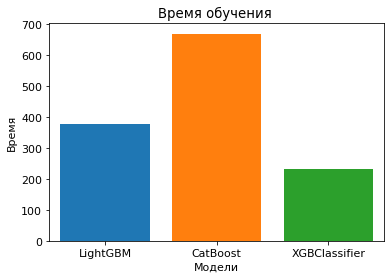

Wall time: 21min 18s


In [66]:
%%time
models = learn_model(models, features_train, features_test, target_train, target_test)

## Выводы.
Выбираем модель градиентного бустинга LightGBM. Мой наилучший скор f1-меры: 0.889 <br>
Наши параметры: 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500